In [ ]:
Project Description: Classifying Astrocyte Cells as Live or Dead Using CNN
This project focuses on developing a Convolutional Neural Network (CNN) to classify images of astrocyte cells into two categories: live and dead. This type of image classification is valuable in biomedical research and drug testing, where detecting cell viability automatically can help streamline experiments and reduce human error.

Due to a small and imbalanced dataset (more live cells than dead ones), we implement key deep learning techniques to improve model performance and generalization:

📁 Image preprocessing and proper directory structure.

🧪 Data augmentation to artificially increase the dataset size and variability.

⚖️ Class weighting to account for imbalanced data during training.

🧠 CNN architecture design suited for small biomedical image datasets.

📊 Performance visualization through training history plots (accuracy and loss over epochs).

We're importing everything we need for building a CNN, handling image data, and managing class imbalance.

In [4]:
# 🔧 Standard Python libraries
import os  # For working with directories and file paths
import numpy as np  # For numerical operations and handling arrays
import matplotlib.pyplot as plt  # For plotting and visualizing data (e.g., accuracy, loss)

# 🧠 TensorFlow: Main deep learning framework used to build and train neural networks
import tensorflow as tf

# 🖼️ ImageDataGenerator: Loads images from folders and applies real-time data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🏗️ Sequential model: A simple stack of layers used to build the CNN
from tensorflow.keras.models import Sequential

# 🧱 CNN building blocks:
from tensorflow.keras.layers import Conv2D     # Convolution layer to detect features (edges, shapes, etc.)
from tensorflow.keras.layers import MaxPooling2D  # Downsampling layer to reduce feature map size
from tensorflow.keras.layers import Flatten    # Flattens 2D feature maps into 1D before passing to Dense layers
from tensorflow.keras.layers import Dense      # Fully connected layer used for decision making (classification)
from tensorflow.keras.layers import Dropout    # Regularization technique to prevent overfitting

# ⚖️ sklearn utility to automatically compute class weights for imbalanced datasets
from sklearn.utils import class_weight
import shutil
import random

Randomly splits your data into 80% training and 20% validation.

Creates a new directory data_split/ with the right structure for ImageDataGenerator.

Keeps the original data untouched.

In [5]:

# Set source and destination directories
original_data_dir = 'data'
split_data_dir = 'data_split'
categories = ['live', 'dead']

# Define split ratio
val_split = 0.2  # 20% for validation

# Create train/val directories
for category in categories:
    for split in ['train', 'val']:
        split_path = os.path.join(split_data_dir, split, category)
        os.makedirs(split_path, exist_ok=True)

# Split and copy files
for category in categories:
    source_dir = os.path.join(original_data_dir, category)
    all_files = os.listdir(source_dir)
    random.shuffle(all_files)

    # Split into train and val
    split_index = int(len(all_files) * (1 - val_split))
    train_files = all_files[:split_index]
    val_files = all_files[split_index:]

    # Copy to new directories
    for f in train_files:
        src = os.path.join(source_dir, f)
        dst = os.path.join(split_data_dir, 'train', category, f)
        shutil.copy2(src, dst)

    for f in val_files:
        src = os.path.join(source_dir, f)
        dst = os.path.join(split_data_dir, 'val', category, f)
        shutil.copy2(src, dst)

print("✅ Dataset successfully split into training and validation sets.")


✅ Dataset successfully split into training and validation sets.


In [6]:
# Define base paths to your dataset
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


This section applies augmentation only to training data to artificially increase dataset size and variation, which helps generalization.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to range [0, 1]
    rotation_range=90,            # Randomly rotate images up to ±90 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,       # Randomly shift images vertically by up to 10%
    zoom_range=0.2,               # Randomly zoom in or out by up to 20%
    horizontal_flip=True,         # Randomly flip images left-to-right
    vertical_flip=True,           # Randomly flip images top-to-bottom
    brightness_range=[0.7, 1.3]   # Randomly adjust brightness within this range
)

# Validation data is not augmented—only rescaled
val_datagen = ImageDataGenerator(
    rescale=1./255                # Normalize validation images as well
)


These generators will:

Load batches of images from the train and val folders.

Apply the transformations we defined.

Provide images and labels to the model during training.

In [8]:
# Define paths to the split training and validation directories
train_dir = 'data_split/train'
val_dir = 'data_split/val'

# Create a generator that loads images in batches from the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,                   # Path to training data
    target_size=(128, 128),      # Resize all images to 128x128
    batch_size=32,               # Number of images per batch
    class_mode='binary',         # For binary classification (live vs. dead)
    shuffle=True                 # Shuffle the data for each epoch
)

# Create a generator for the validation data (no augmentation applied)
val_generator = val_datagen.flow_from_directory(
    val_dir,                     # Path to validation data
    target_size=(128, 128),      # Resize all images to 128x128
    batch_size=32,               # Number of images per batch
    class_mode='binary',         # Same binary classification
    shuffle=False                # Don't shuffle; useful for evaluation later
)


Found 3069 images belonging to 2 classes.
Found 768 images belonging to 2 classes.


Class 'dead' has 635 images
Class 'live' has 2434 images


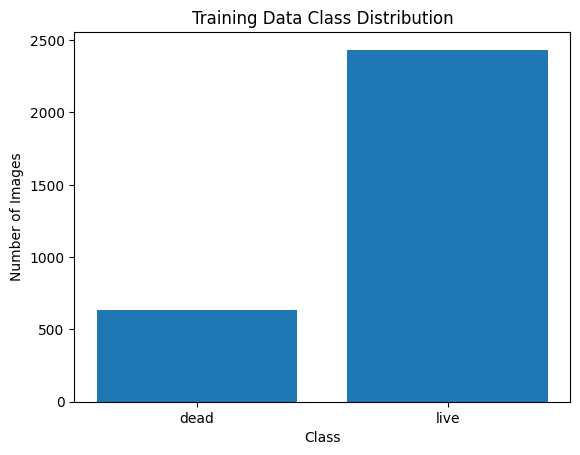

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Access class labels (0 or 1) from the training generator
class_counts = np.bincount(train_generator.classes)

# Map indices to class names
class_indices = train_generator.class_indices
inverse_class_indices = {v: k for k, v in class_indices.items()}

# Print counts
for i, count in enumerate(class_counts):
    print(f"Class '{inverse_class_indices[i]}' has {count} images")

# Plot
plt.bar(inverse_class_indices.values(), class_counts)
plt.title("Training Data Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


 Tell the model to “pay more attention” to the minority class (in this case, dead cells) during training.



In [46]:
# 📦 Import required libraries
from sklearn.utils import class_weight
import numpy as np

# 🧾 Extract the actual class labels from the training generator
# These are the ground-truth labels (0 = 'dead', 1 = 'live'), one per training image
labels = train_generator.classes

# ⚖️ Compute class weights based on how many samples are in each class
# 'balanced' mode gives higher weight to underrepresented classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',    # Automatically adjust weights to balance classes
    classes=np.unique(labels),  # The distinct class labels (should be [0, 1])
    y=labels                    # Actual labels from the dataset
)

# 🧭 Convert weights into a dictionary format Keras expects
# Example: {0: 1.9, 1: 0.5}
class_weights = dict(enumerate(weights))

# 🖨️ Print the resulting weights so we can review them
print("Class weights:", class_weights)


Class weights: {0: 2.416535433070866, 1: 0.6304437140509449}


Step: Build the CNN Model
Goal: Define a simple but effective CNN architecture that can learn from augmented cell images.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([

    # Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),                # 🔍 Normalize activations
    MaxPooling2D(2, 2),

    # Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Optional: Layer 4 (only if you want to keep it)
    # Conv2D(256, (3, 3), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(2, 2),

    # Flatten and fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),                        # Keep dropout for regularization
    Dense(1, activation='sigmoid')       # Output layer for binary classification
])


Step: Compile the CNN Model
Goal: Prepare the model for training by specifying the loss function, optimizer, and evaluation metric.



In [48]:
# ⚙️ Compile the model with an appropriate optimizer, loss function, and metric
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower than default 0.001
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Step: View Model Summary
Goal: Understand how many layers and trainable parameters your model has.



In [49]:
# 🧾 Display the architecture of the model
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

Step: Train the Model
Goal: Train the CNN on the augmented training data and evaluate it on the validation set.



In [50]:
from tensorflow.keras.callbacks import EarlyStopping

# ⏹️ Stop training if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',           # What to watch
    patience=3,                   # How many epochs to wait for improvement
    restore_best_weights=True     # Go back to the best model after stopping
)


# 🚀 Train the model using the training data and validate on validation data
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,                         # You can increase this now (e.g., 25–30)
    class_weight=class_weights,
    callbacks=[early_stop]            # 👈 Add this line!
)


Epoch 1/30
96/96 [==============================] - 77s 766ms/step - loss: 0.7780 - accuracy: 0.6937 - val_loss: 0.5362 - val_accuracy: 0.7943
Epoch 2/30
96/96 [==============================] - 75s 775ms/step - loss: 0.5494 - accuracy: 0.7559 - val_loss: 0.5577 - val_accuracy: 0.7526
Epoch 3/30
96/96 [==============================] - 74s 765ms/step - loss: 0.5090 - accuracy: 0.7784 - val_loss: 0.4730 - val_accuracy: 0.7969
Epoch 4/30
96/96 [==============================] - 75s 775ms/step - loss: 0.4738 - accuracy: 0.7947 - val_loss: 0.7398 - val_accuracy: 0.6445
Epoch 5/30
96/96 [==============================] - 73s 757ms/step - loss: 0.4161 - accuracy: 0.8221 - val_loss: 0.4959 - val_accuracy: 0.7591
Epoch 6/30
96/96 [==============================] - 69s 722ms/step - loss: 0.4120 - accuracy: 0.8227 - val_loss: 0.4024 - val_accuracy: 0.8164
Epoch 7/30
96/96 [==============================] - 73s 759ms/step - loss: 0.4277 - accuracy: 0.8254 - val_loss: 0.4393 - val_accuracy: 0.8138

Step: Plot Accuracy and Loss Curves
Goal: Visualize how training and validation performance evolved over epochs.



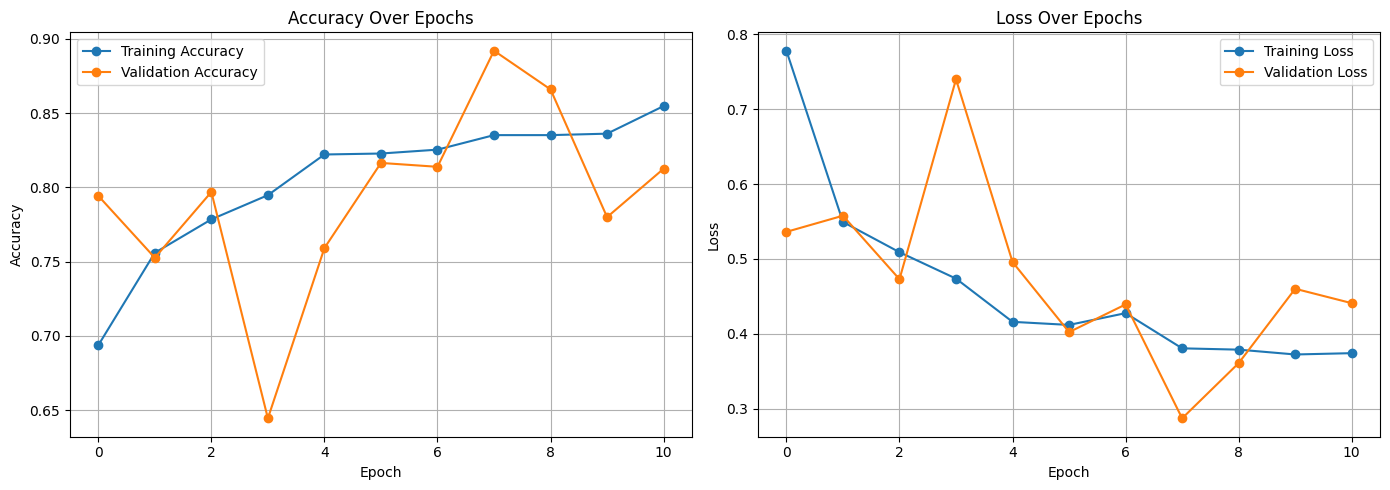

In [51]:
import matplotlib.pyplot as plt

# 🎯 Extract training history from the model
acc = history.history['accuracy']             # Training accuracy
val_acc = history.history['val_accuracy']     # Validation accuracy

loss = history.history['loss']                # Training loss
val_loss = history.history['val_loss']        # Validation loss

# 📈 Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 📉 Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Step: Evaluate the Model on Validation Data
Goal: Get a detailed picture of performance using the validation set.



In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels
true_labels = val_generator.classes

# Predict probabilities
pred_probs = model.predict(val_generator)

# Convert probabilities to binary predictions (0 or 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()


24/24 [==============================] - 13s 554ms/step


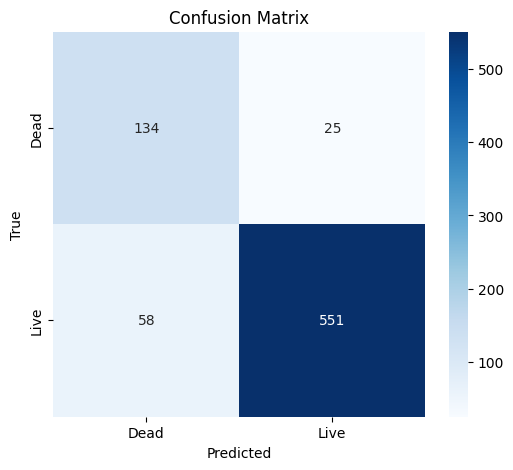

Classification Report:

              precision    recall  f1-score   support

        dead       0.70      0.84      0.76       159
        live       0.96      0.90      0.93       609

    accuracy                           0.89       768
   macro avg       0.83      0.87      0.85       768
weighted avg       0.90      0.89      0.90       768



In [53]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dead', 'Live'], yticklabels=['Dead', 'Live'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Get readable class names
class_names = list(val_generator.class_indices.keys())

# Generate precision, recall, F1, and support
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n")
print(report)


In [55]:
model.save('astrocyte_live_dead_model.keras')  # 💾 Modern Keras format
